# Boosting Classifier Model
### Ivan Alfredo Rodrigo

La sessió consisteix en crear un boosting classifier amb _decision trees_ de la llibreria sklearn com a _weak model_. 

Boosting (https://en.wikipedia.org/wiki/Boosting_(machine_learning)): tècnica d'aprenentatge automàtic que consiteix en entrenar múltiples models (_weak models_) seqüencialment per obtenir un model general _strong model_. Podem definir un _weak learner_ o _weak model_ com un classificador el qual està lleugerament correlacionat amb problema final i que és millor que intentar-ho encertar aleatòriament, és a dir, que no ha de veure tot el problema sener; considerem que un model weak learner si encerta entre el 55% i el 65% de bo. La idea és que cada _weak model_ es centra en una feature concreta o en arreglar els errors del classificador anterior.

En essència, el _boosting_ respon a la pregunta següent:

```Can a set of weak learners create a strong single learner? ```

La resposta a aquesta pregunta es **sí**, i ho veurem en aquesta sessió.

En el cas concret dels **classificadors** el que hem d'aconseguir és el següent: 
```
[...] most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight.[note 1] Thus, future weak learners focus more on the examples that previous weak learners misclassified._
```

## Context

El dataset en qüestió (https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) és un dataset d'assegurançes, el qual vol predir si els seus actuals clients estarien interessats en també adquirir una *assegurança de cotxe*. És a dir, de cilents ja existents d'una asseguradora, quina és la probabilitat de que els hi interessi adquirir una assegurança de cotxe per al seu vehicle. Anem a explorar el Dataset:

In [1]:
#Generate Baseline solution with a RandomForest
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
tabla_valores = df.copy()

In [3]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [4]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [5]:
df['Gender'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [6]:
gender_mapping = {'Male': 1, 'Female': -1}
tabla_valores['Gender'] = df['Gender'].replace(gender_mapping)

In [7]:
df['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [8]:
vAge_mapping = {'1-2 Year': 3/2, '< 1 Year': 1, '> 2 Years': 2}
tabla_valores['Vehicle_Age'] = df['Vehicle_Age'].replace(vAge_mapping)

In [9]:
df['Vehicle_Damage'].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [10]:
vDamage_mapping = {'Yes': 1, 'No': -1}
tabla_valores['Vehicle_Damage'] = df['Vehicle_Damage'].replace(vDamage_mapping)

In [11]:
tabla_valores.dtypes

id                        int64
Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age             float64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Fem una petita investigació de les classes de resposta

Total de zeros: 334399, percentual: 87.74%
Total de uns: 46710, percentual: 12.26%


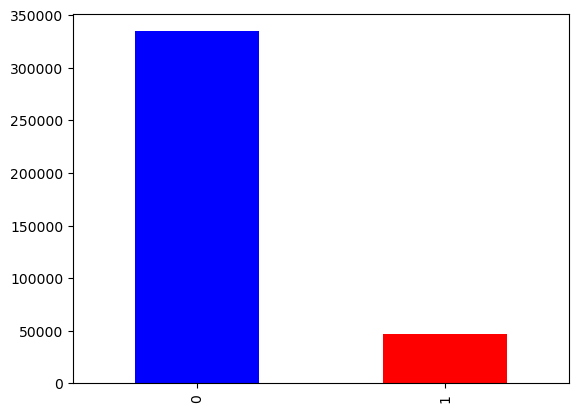

In [12]:
response = df["Response"].value_counts()
response.plot(kind='bar', color=['blue', 'red'])

zeros, ones = response[0]/df.shape[0], response[1]/df.shape[0]

print(f"Total de zeros: {response[0]}, percentual: {round(zeros,4)*100}%")
print(f"Total de uns: {response[1]}, percentual: {round(ones,4)*100}%")


És a dir, ens trobem davant del que es diu un dataset desequilibrat, o bé un _imabalanced dataset_, on hi ha moltes més observacions d'una classe o de l'altra. En general, aquest no és un cas ideal ja que pot portar a diferents problemes. Hi ha múltiples maneres de solucionar-ho, i a la pràctica us demanem que ho arregleu amb una _Weighted Binary Cross Entropy_

## Binary Cross Entropy o Log Loss

En binari ens referim al tipus de classifició entre dues classes. Per el model saber com de bé està classificant entre les dues classes, mira a l'espai n-dimensional de característiques com de lluny està el valor que ha donat a una observació. Aquesta "distància" és el que s'anomena la _loss function_, que en el cas de la classificació binària és

$L_B = -\cfrac{1}{N} \sum_{i=0}^N[y_i log(p_i) + (1-y_i)log(1-p_i)]$, on $N$ són les observacions, $y_i$ és el valor de veritat i $p_i$ és la probabilitat predita per la mostra $i$

Concretament (i com es desil·la de l'expressió) la formula calcula la pèrdua (com de lluny s'ha quedat la precció) comparant la probabilitat predita amb el valor real de l'observació, per tant, com més lluny està la predicció de la veritat, pitjor pèrdua té i més gran és el valor de la funció.

Transpira de l'explicació doncs, que si tenim moltes més mostres d'una classe que de l'altra el valor de la funció de pèrdua queda esbiaixat cap a la predicció d'una classe.

## Weighted Binary Cross Entropy

La idea és equilibrar el desbalançeig de mostres afegint un coeficient que faci que la pèrdua de la classe minoritària tingui més pes que no la de la classe majoritària:

$L_{WB} = -\cfrac{1}{N} \sum_{i=0}^N[w_1 y_i log(p_i) + w_0 (1-y_i)log(1-p_i)]; w_0 +w_1 = 1$

On $w_1$ és el pes de la classe majoritària i $w_0$ és el pes de la classe minoritària. El pesos han de ser inversament proporcionals a les freqüències de les classes, ergo tenint la classe minoritària (1) un pes més gran que la majoritària (0)


## Baseline

Una _baseline_ és una procediment de _benchmarking_ per comparar com el teu model funciona. Aquests han de ser senzills i ràpids d'implementar, i no tenen perque ser molt millors que endevinar aleatòriament la resposta. S'usen per comparar amb les modificacions que volem fer, de manera que vegem que el _boosting_ està millorant una aproximació ingènua dins de l'aprenentatge automàtic i per jutjar si val la pena!

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import data
train = pd.read_csv('train.csv',)
test = pd.read_csv('test.csv')

#train the model -> this is a baseline, only the simple features are used
model = RandomForestClassifier()
X = train[['Age','Driving_License','Annual_Premium','Vintage','Region_Code']]
y = train['Response']
model.fit(X,y)
y_train = model.predict(X)

accuracy = accuracy_score(y, y_train)
precision = precision_score(y, y_train)
recall = recall_score(y, y_train)
f1 = f1_score(y, y_train)
roc_auc = roc_auc_score(y, y_train)

# evaluate the test set
X_test = test[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y_test = model.predict(X_test)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.9960352550057857
Precision: 0.9945727103621841
Recall: 0.9729608220937701
F1: 0.9836480709918295
ROC AUC: 0.9861095965408608


In [14]:
# save our predictions in the Kaggle formats
test['Response'] = y_test
test[['id','Response']].to_csv('my_solution.csv',index=None)

## Regular el desbalance

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
tabla_valores_balanced_X, tabla_valores_balanced_Y = rus.fit_resample(tabla_valores.drop("Response", axis=1), tabla_valores['Response'])

# Convertir y_resampled a DataFrame y darle un nombre de columna
tabla_valores_balanced_Y = pd.DataFrame(tabla_valores_balanced_Y, columns=['Response'])

# Concatenar X_resampled y df_y_resampled a lo largo de las columnas (axis=1)
tabla_valores_balanced = pd.concat([pd.DataFrame(tabla_valores_balanced_X), tabla_valores_balanced_Y], axis=1)


Total de zeros: 46710, percentual: 12.26%
Total de uns: 46710, percentual: 12.26%


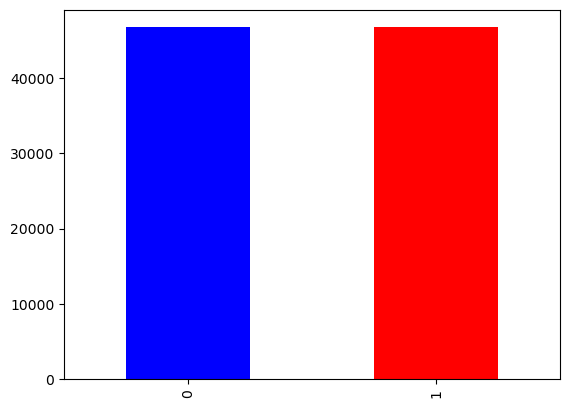

In [16]:
response = tabla_valores_balanced['Response'].value_counts()
response.plot(kind='bar', color=['blue', 'red'])

zeros, ones = response[0]/df.shape[0], response[1]/df.shape[0]

print(f"Total de zeros: {response[0]}, percentual: {round(zeros,4)*100}%")
print(f"Total de uns: {response[1]}, percentual: {round(ones,4)*100}%")

# Feature Engineers

In [17]:
corr_matrix = tabla_valores.corr()
corr_matrix['Response'].sort_values(ascending=False)

Response                1.000000
Vehicle_Damage          0.354400
Vehicle_Age             0.221874
Age                     0.111147
Gender                  0.052440
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
id                     -0.001368
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
Name: Response, dtype: float64

In [18]:
print(tabla_valores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  int64  
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  float64
 7   Vehicle_Damage        381109 non-null  int64  
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 34.9 MB
None


In [19]:
# Podem observar que no tenim cap valor null

In [20]:
# Plot de les variables numèriques per veure si tenim un gran percentatge de valors 0
tabla_valores.describe()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,0.081523,38.822584,0.997869,26.388807,0.458210,1.304808,0.009753,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,0.996673,15.511611,0.046110,13.229888,0.498251,0.283720,0.999954,17213.155057,54.203995,83.671304,0.327936
min,1.000000,-1.000000,20.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,-1.000000,25.000000,1.000000,15.000000,0.000000,1.000000,-1.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,1.000000,36.000000,1.000000,28.000000,0.000000,1.500000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,1.000000,49.000000,1.000000,35.000000,1.000000,1.500000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [21]:
# Com podem observar no tenim cap variable amb un valor 0 que no hauria d'estar

# Tasques

1. Completeu la classe _BoostingClassifier_ i els seus dos mètodes _fit_ i _predict_ com veieu més adhient per obtenir els millors resultats al Dataset.
2. Implementeu la funció *balance_weights* per veure quin pes assigna a cada vector.

La idea és que trobeu quin calcul d'error, quin learning rate i quin estil de predicció dona millors resultats, també com quin repartiment de pesos balançeja millor el dataset. 

NOTA: per a que el resultat sigui el millor possible podeu tractar el dataset amb les eines apreses a les sessions 1 i 2 (tractament de categòriques, mirar correlacions, estratificar el train i test...).

3. Penjeu els millors resultats al Kaggle!


In [22]:
import sklearn
import numpy as np

class BoostingClassifier:
    def __init__(self, X: np.array, y: np.array, w: np.array):
        self.X = X
        self.y = y
        self.weights = w / w.sum()  # Normalize initial weights
        self.n = X.shape[0]
        self.trees = []  # Store weak learners
        self.learning_rates = []
        #self.predictions = [] # es poden guardar les prediccions en comptes dels arbres

    def fit(self, num_trees, shrinkage=1.0, factor=1.0):
        for m in range(num_trees):
            # Train weak learner
            tree = sklearn.tree.DecisionTreeClassifier(max_depth=2)
            tree.fit(self.X, self.y, sample_weight=self.weights)
            predictions = tree.predict(self.X)
            
            """
            TODO:
            1. Calcular les mostres mal classificades
            2. Calcular l'error de l'arbre
            3. Actualitzar els pesos segons la predicció d'aquesta iteració
            4. Calcular el Learning Rate
            5. Guardar les variables
            """
            # 1. Calcular les mostres mal classificades
            misclassified = predictions != self.y
            
            # 2. Calcular l'error de l'arbre
            error = np.sum(self.weights[misclassified]) / np.sum(self.weights)
            
            # 3. Actualitzar els pesos segons la predicció d'aquesta iteració
            beta = error / (1 - error)
            self.weights *= np.power(beta, (1 - misclassified).astype(int))
            
            # 4. Calcular el Learning Rate
            learning_rate = shrinkage / (1.0 + m * factor)
            self.learning_rates.append(learning_rate)
            
            # 5. Guardar les variables
            self.trees.append((tree, learning_rate))

    def predict(self, X):
        """
        TODO: MÈTODE QUE AJUNTI LES PREDICCIONS DELS ARBRES AMB UNA COMBINACIÓ LINEAL DELS PESOS.
        """
        result = np.zeros(X.shape[0])
        
        for tree, learning_rate in self.trees:
            result += learning_rate * tree.predict(X)
        
        return np.sign(result)
        

def balance_weights(responses: list):
    """
    Assignates different weights depending on the class

    Args:
        responses binary vector
    
    Returns:
        list[float] with numbers between zero and one being the starting weight
    """
    class_counts = np.bincount(responses)
    
    total_samples = responses.shape[0]
    
    weights = total_samples / (len(class_counts) * class_counts[responses])
    
    return weights

In [23]:
from sklearn.model_selection import train_test_split

# Uso de la función balance_weights
response_column = tabla_valores_balanced['Response'].values
weights = balance_weights(response_column)

# Creación de una instancia de BoostingClassifier
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(tabla_valores_balanced.drop('Response', axis=1), response_column, weights, test_size=0.2, random_state=42)
boosting_classifier = BoostingClassifier(X_train, y_train, w_train)

# Ajuste del clasificador
boosting_classifier.fit(num_trees=10)

# Predicción en el conjunto de prueba
predictions = boosting_classifier.predict(X_test.values)

# Evaluación del rendimiento
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.74443374009848


/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/

In [24]:
# A EXECUTAR QUAN ESTIGUI FET
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tabla_valores_balanced.drop('Response', axis=1), tabla_valores_balanced['Response'].values, test_size=0.4)

initial_weights = balance_weights(y_train)

bc = BoostingClassifier(X_train, y_train, initial_weights)
bc.fit(15, shrinkage=0.1, factor = 1.55)

test = pd.read_csv('test.csv')
test_copy = test.copy()

gender_mapping = {'Male': 1, 'Female': -1}
test['Gender'] = test_copy['Gender'].replace(gender_mapping)

vAge_mapping = {'1-2 Year': 3/2, '< 1 Year': 1, '> 2 Years': 2}
test['Vehicle_Age'] = test_copy['Vehicle_Age'].replace(vAge_mapping)

vDamage_mapping = {'Yes': 1, 'No': -1}
test['Vehicle_Damage'] = test_copy['Vehicle_Damage'].replace(vDamage_mapping)

result = bc.predict(test.values)

test['Response'] = result
test[['id','Response']].to_csv('my_solution.csv',index=None)


/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/ivan/anaconda3/lib/

# Preguntes
Per acabar, contesteu les següents preguntes:
1. Quines mètriques heu fet servir per avaluar els models? Com depenen aquestes mètriques segons el balanç del model?
2. Prova d'inicialitzar el model amb els pesos a $1/n$. Hi ha diferència entre pesos uniformes o cambiants per classe?
3. Descriu breument l'estratègia d'actualitzar pesos, calcul d'errors, calcul de learning rate i predicció final. Investiga quines són les estratègies que utilitza el model AdaBoost i discuteix com de similars són les teves.
4. Distuteix i compara els resultats amb els següents models de baseline: RandomForest, Bagging i AdaBoost.

## --- Respostes ---
1) L'única mètrica que se fa servir per avaluar lo model és: <b>l'accuracy</b>, se calcula com la suma dels casos correctes dividit pel nombre total de mostres al conjunt de prova. Cal remarcar que aquest procés es acceptat quan les classes estan balancejades, per aixó abans d'avaluar intentem igualar la classe minoritaria i majoritaria perque si no, el model tindria tendencia cap a la que té mes dades. 

2) Los pesos inicials se troben en la funció <b>balance_weights</b> que assigna pesos diferents depenent de la classe, aixó dona més pes a la minoritaria per a que l'aprengui millor. Si s'inicialitzen els pesos a $1/n$, es donarà el mateix pes a totes les mostres i per tant les mostres minoritaries passarien desapercebudes per la classe majoritaria. Clarament, si que hi ha diferencia.

3) - <b>Actualització de pesos:</b> Se calculen les mostres mal classificades i es fan servir per actualitzar els pesos mitjançant la fórmula de boosting.
   - <b>Càlcul d'errors:</b> Se calcula l'error de l'arbre basant-se en les mostres mal classificades i se fa servir per ajustar els pesos.
   - <b>Càlcul de learning rate:</b> El learning rate se calcula mitjançant una fórmula que inclou el paràmetre de shrinkage i un factor que pot ser modificat.
   - <b>Predicció final:</b> Se combinen les prediccions dels arbres amb una combinació lineal dels pesos, i la predicció final se calcula prenent el signe d'aquesta combinació.<br>
   Lo model adaBoost també usa pesos majors per donar mes importantcia a les mostres mal classificades, però l'implementeció pot tenir diferencies
   
4) Comparació en:
   - <b>RandomForest:</b> RandomForest crea diversos arbres de decisió i combina les seves prediccions. És més robust a l'overfitting i funciona bé per conjunts de dades desbalancejats. Pot ser més eficaç que AdaBoost en algunes situacions, especialment quan les classes no estan fortament desbalancejades.
   - <b>Bagging:</b> Bagging també construeix múltiples models, però cada model s'entrena amb una mostra de dades aleatòria. Funciona bé amb models forts i redueix la variança, però no dóna pes addicional a les mostres mal classificades com ho fa AdaBoost.
   - <b>AdaBoost:</b> AdaBoost és una tècnica d'ensemble que assigna pesos a les mostres per corregir errors successivament. Té una forta orientació a les classes mal classificades, donant-los més pes en cada iteració. És més sensible al soroll i als outliers, però pot ser eficaç en conjunts de dades desbalancejats.<br>
      La comparació de resultats clarament depent sempre de les dades amb les que executem lo model, abans de balancejar-lo hagues sigut millor el RandomForest posteriorment com veiem donar millor resultat el Boosting que esta basat en l'adaBoost

## Entrega: 11 de Desembre de 2023, 23:59

# ANNEX

##### Vam voler crear noves columnes que aportaven característiques diferents a les ja donades de base per data set, aixó no millorava molt l'accuracy i per tant no es va acabar implementant en el model final.
Aquí afegim aquest estudi de les features i com es van treballar:

In [25]:
corr_matrix = tabla_valores.corr()
corr_matrix['Response'].sort_values(ascending=True)

Previously_Insured     -0.341170
Policy_Sales_Channel   -0.139042
id                     -0.001368
Vintage                -0.001050
Driving_License         0.010155
Region_Code             0.010570
Annual_Premium          0.022575
Gender                  0.052440
Age                     0.111147
Vehicle_Age             0.221874
Vehicle_Damage          0.354400
Response                1.000000
Name: Response, dtype: float64

<Axes: >

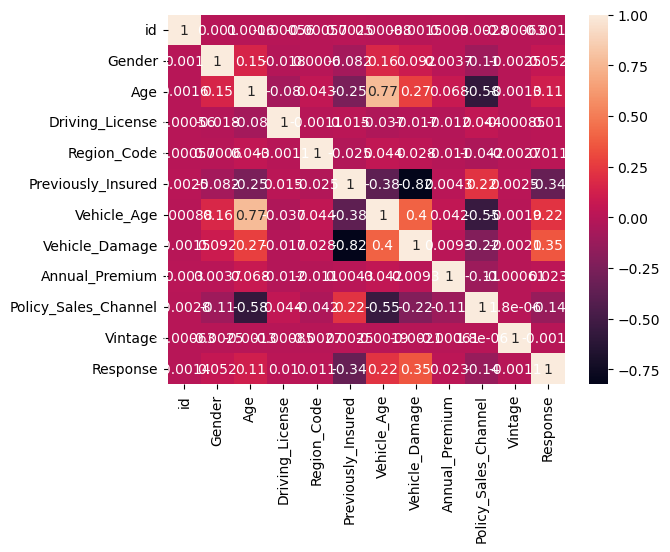

In [26]:
correlation_matrix = tabla_valores.corr()
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)

In [27]:
Response_corr = correlation_matrix['Response']
umbral_correlacion = 0.2

exclusion_list = ['Response']

features = [col for col in correlation_matrix.columns if (abs(Response_corr[col]) > umbral_correlacion) and (col not in exclusion_list)]

print('COLUMNAS PRINCIPALES QUE ESTAN RELACIONADAS CON La RESPUESTA')
print(features)

COLUMNAS PRINCIPALES QUE ESTAN RELACIONADAS CON La RESPUESTA
['Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']


In [28]:
# Iterar por la matriz de correlación
columnas_relacionadas = {}
for column in tabla_valores.columns:
    if column not in features and column not in exclusion_list:
        columnas_relacionadas[column] = list(correlation_matrix[column][abs(correlation_matrix[column]) > umbral_correlacion].index)
# Imprimir las columnas relacionadas
print('CARACTERISTICAS CORRELACIONADAS CON CARACTERISTICAS NO PRINCIPALES ')
for columna, columnas_relacionada in columnas_relacionadas.items():
    print(f'     Columna: {columna} - Columnas relacionadas: {columnas_relacionada}')
    
# Encontrar columnas con exactamente una relación y ninguna otra
no_correlacionadas = []
si_correlacionadas = []
for columna, columnas_relacionada in columnas_relacionadas.items():
    if(len(columnas_relacionada)==1):
        no_correlacionadas.append(columna)
    else:
        si_correlacionadas.append(columna)
print('')
print('COLUMNAS QUE NO ESTAN RELACIONADAS CON NINGUNA OTRA CARACTERÍSTICA')
print(f'     {no_correlacionadas}')

CARACTERISTICAS CORRELACIONADAS CON CARACTERISTICAS NO PRINCIPALES 
     Columna: id - Columnas relacionadas: ['id']
     Columna: Gender - Columnas relacionadas: ['Gender']
     Columna: Age - Columnas relacionadas: ['Age', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
     Columna: Driving_License - Columnas relacionadas: ['Driving_License']
     Columna: Region_Code - Columnas relacionadas: ['Region_Code']
     Columna: Annual_Premium - Columnas relacionadas: ['Annual_Premium']
     Columna: Policy_Sales_Channel - Columnas relacionadas: ['Age', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
     Columna: Vintage - Columnas relacionadas: ['Vintage']

COLUMNAS QUE NO ESTAN RELACIONADAS CON NINGUNA OTRA CARACTERÍSTICA
     ['id', 'Gender', 'Driving_License', 'Region_Code', 'Annual_Premium', 'Vintage']


<Axes: >

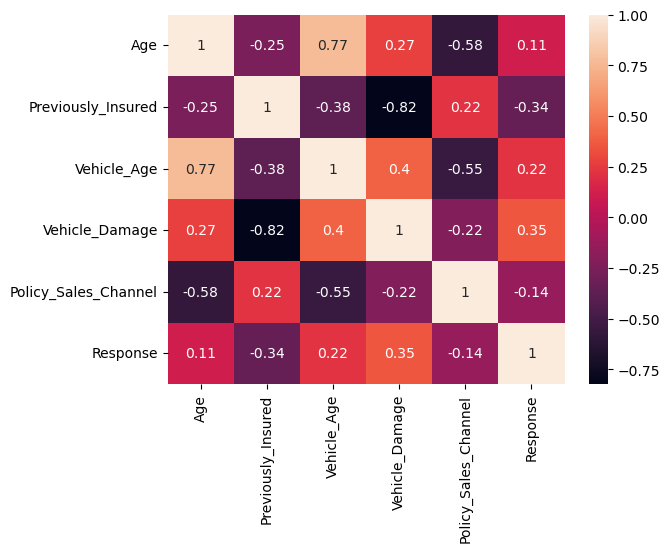

In [29]:
# Eliminar las columnas
tabla_valores_clean = tabla_valores.drop(no_correlacionadas, axis=1)  #axis = 0 ELIMINA FILAS

correlation_matrix_2 = tabla_valores_clean.corr()
# Puedes visualizar la matriz de correlación, por ejemplo, usando seaborn o matplotlib.
import seaborn as sns
sns.heatmap(correlation_matrix_2, annot=True)

<Axes: >

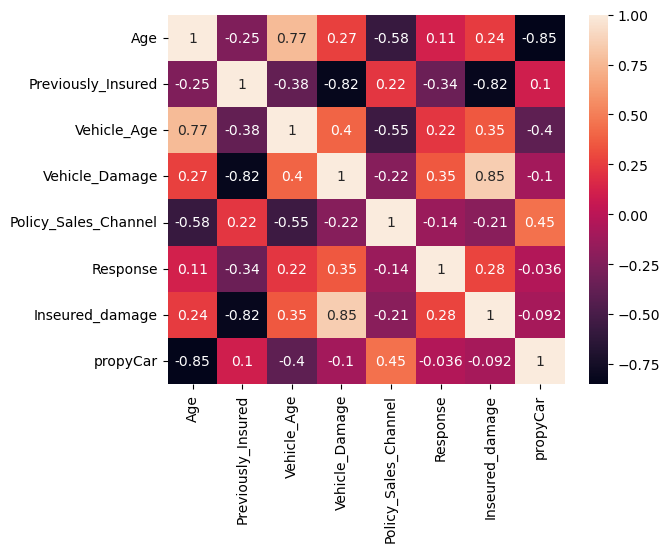

In [30]:
tabla_valores_clean["Inseured_damage"] = tabla_valores_clean["Previously_Insured"] / tabla_valores_clean["Vehicle_Damage"]
tabla_valores_clean['propyCar'] = tabla_valores_clean['Vehicle_Age'] / tabla_valores_clean['Age']
correlation_matrix_final = tabla_valores_clean.corr()
# Puedes visualizar la matriz de correlación, por ejemplo, usando seaborn o matplotlib.
import seaborn as sns
sns.heatmap(correlation_matrix_final, annot=True)

In [31]:
Response_corr = correlation_matrix_final['Response']
umbral_correlacion = 0.2

exclusion_list = ['Response']

features = [col for col in correlation_matrix_final.columns if (abs(Response_corr[col]) > umbral_correlacion) and (col not in exclusion_list)]

print('COLUMNAS PRINCIPALES QUE ESTAN RELACIONADAS CON La RESPUESTA')
print('')
print('estas tienen que ser las columnas de nuestra data set final:')
print('')
print(features)

COLUMNAS PRINCIPALES QUE ESTAN RELACIONADAS CON La RESPUESTA

estas tienen que ser las columnas de nuestra data set final:

['Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Inseured_damage']
